<a href="https://colab.research.google.com/github/carlosperezm/covid_time_series/blob/main/covid_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

 - Data exploration
  - Plots
    - Stationary / non stationary
  -Outliers
- Split the database in training and test part
 - ARIMA
   - Characterization
   - 


# Introduction
This is a placeholder for the introduction

In [ ]:
import pandas as pd
import numpy as np
import requests
import altair as alt

In [ ]:
BASE = "https://disease.sh/"
DISEASE = "v3/covid-19/"
HISTORICAL = "historical/"
COLOMBIA = "Colombia"
SPAIN = "Spain"
FRANCE = "France"

We are recovering the data from the `disease.sh` API. This organizes data from the John Hopkins University in a `JSON` format. We use the python package `requests` to send a POST request to the API. The function accepts an optional parameter to get country data. If not specified, it returns the full historical data for all countries.

In [ ]:
def load_data_covid(country=None):
    if type(country) is str:
      try:
          r = requests.get(f"{BASE}{DISEASE}{HISTORICAL}{country}", params={"lastdays": "all"})
          r.raise_for_status()
      except requests.exceptions.HTTPError as err:
          print(err)
          return
      else:
          df = pd.concat({r.json()['country']: pd.DataFrame.from_dict(r.json()["timeline"])}).reset_index()

    else:
      try:
          r = requests.get(f"{BASE}{DISEASE}{HISTORICAL}", params={"lastdays": "all"})
          r.raise_for_status()
      except requests.exceptions.HTTPError as err:
          print(err)
          return
      else:
          df = pd.concat({c['country']: pd.DataFrame.from_dict(c["timeline"]) for c in r.json()}).reset_index()

    cols={'level_0':'country', 'level_1': 'date', 'cases':'total_cases', 'deaths': 'total_deaths', 'recovered': 'total_recoveries'}
    df = df.rename(columns=cols)
    df["date"] = pd.to_datetime(df["date"])
    return df

Unfortunately the dataset from John Hopkins has some inconsistencies in the reports of the data, namely the accumulated number of deaths, recoveries and cases. Sometimes the number reported is less than the previous day, which should not be possible in this context.
To address the issues, we decided to replace the data point with the corresponding one from the previous date if the subtraction from the previous day is negative.

In [ ]:
def process_totals_errors(full_data):
    cols= ['total_cases', 'total_deaths', 'total_recoveries']
    # Mask to identify incorrect subtraction when changing country in the table
    mask = full_data['country'] != full_data['country'].shift(1)
    for col in cols:
        full_data[col]= full_data[col].mask((full_data[col].diff()< 0), np.nan)
        full_data = full_data.fillna(method='ffill')
        full_data.loc[mask, col] = np.nan
        full_data = full_data.fillna(0)
    return full_data

To produce more meaningful results, we added three new columns of data, to get the number of new cases, deaths and recoveries, updated in a daily manner. We obtained them by subtracting each data value by the previous one. In the aggregated data for each country, the subtraction is done with the last value of the previous column. We also replace the NaN values in the first row of the dataframe by 0.

In [ ]:
def add_daily_data(df):
    # Calculate the diff for the total columns to get the new values
    temp = df.groupby(['country', 'date'])[['total_cases', 'total_deaths', 'total_recoveries']]
    temp = temp.sum().diff().reset_index()
    cols= ['new_cases', 'new_deaths', 'new_recoveries']
    temp.columns = ['country', 'date', *cols]

    # merge new cases with the original dataframe
    full_grouped = pd.merge(df, temp, on=['country', 'date'])

    # replace all negative values with zeros (happens in the first row of each country)
    full_grouped[cols] = full_grouped[cols].clip(lower=0)

    full_grouped = full_grouped.fillna(0)

    # add active cases
    full_grouped['active_cases'] = full_grouped['total_cases'] - full_grouped['total_deaths'] - full_grouped['total_recoveries']
    
    return full_grouped.convert_dtypes()

Now we load and process the data using the previous functions.

In [ ]:
full_data = load_data_covid()
full_data = process_totals_errors(full_data)
full_data = add_daily_data(full_data)
full_data

,country,date,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries,active_cases
0,Afghanistan,2020-01-22,0,0,0,0,0,0,0
1,Afghanistan,2020-01-23,0,0,0,0,0,0,0
2,Afghanistan,2020-01-24,0,0,0,0,0,0,0
3,Afghanistan,2020-01-25,0,0,0,0,0,0,0
4,Afghanistan,2020-01-26,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
61688,Zimbabwe,2020-12-05,10617,291,8844,70,10,42,1482
61689,Zimbabwe,2020-12-06,10718,291,8880,101,0,36,1547
61690,Zimbabwe,2020-12-07,10839,294,8972,121,3,92,1573
61691,Zimbabwe,2020-12-08,10912,303,9062,73,9,90,1547


In [ ]:
full_data[full_data["country"].eq("USA")]

,country,date,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries,active_cases
57171,USA,2020-01-22,0,0,0,0,0,0,0
57172,USA,2020-01-23,1,0,0,1,0,0,1
57173,USA,2020-01-24,2,0,0,1,0,0,2
57174,USA,2020-01-25,2,0,0,0,0,0,2
57175,USA,2020-01-26,5,0,0,3,0,0,5
...,...,...,...,...,...,...,...,...,...
57489,USA,2020-12-05,14581318,281186,5576026,213881,2254,105637,8724106
57490,USA,2020-12-06,14756982,282299,5624444,175664,1113,48418,8850239
57491,USA,2020-12-07,14949417,283703,5714557,192435,1404,90113,8951157
57492,USA,2020-12-08,15165295,286249,5786915,215878,2546,72358,9092131


# Data visualization
Now we start visualizing the data to get more insights.

We select a list of countries to explore



In [ ]:
countries = ['USA', 'Italy', 'Spain', 'Germany', 'Iran', 'UK', 'Colombia', 'France']

In [ ]:
plots={}
for country in countries:
  plots[country] = (
      alt.Chart(full_data[full_data["country"].eq(country)].melt("date"))
      .mark_line()
      .encode(x="date:T", y="value:Q", color="variable")
      .properties(title=f"Covid cases {country}", width=500, height=250,)
      .interactive()
  )

In [ ]:
for plot in plots.values():
  display(plot)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [ ]:
selected_countries = full_data[full_data['country'].isin(countries)]

alt.Chart(selected_countries).mark_circle().encode(
    x='date:T',
    y='country',
    color='country',
    size=alt.Size('new_cases:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='Daily new cases')
    ) 
).properties(
    width=700,
    height=400,
    title="Daily cases"
).interactive()

alt.Chart(...)

# ARIMA prediction

TODO

# PROPHET prediction


This example is done with total cases in Colombia

In [ ]:
cases_colombia = full_data[full_data["country"].eq("Colombia")]
cases_colombia=cases_colombia[['date','total_cases']]

# For Prophet to predict, its required for the names on the variables to be ds and y
cols = cases_colombia.columns
cases_colombia.rename(columns= {cols[0]: 'ds', cols[1]:'y'}, inplace= True)

In [ ]:
from fbprophet import Prophet

model_colombia=Prophet()

Add seasonality

In [ ]:
# average month lenght in days in 30.42
model_colombia.add_seasonality(name="Monthly", period=30.42, fourier_order=5)

We define a train test split for this model. Since this is a time series dataset, we cannot use a random split. Instead, we save the last part for testing

In [ ]:
def train_test_split(dataframe, percentage):
    """
    Parameters:
    dataframe: Dataframe to split
    percentage: Percentage of training split
    """
    divisor = round((percentage/100)*dataframe.shape[0])
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test

In [ ]:
cases_colombia_train, cases_colombia_test = train_test_split(cases_colombia, 70)

In [ ]:
model_colombia.fit(cases_colombia_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Creating future dates
future_dates = model_colombia.make_future_dataframe(periods=72)

In [ ]:
# Making predictions
forecast = model_colombia.predict(future_dates)

In [ ]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
293,2020-11-10,1.336736e+06,1.250466e+06,1.408384e+06,1.253090e+06,1.410935e+06,-940.520693,-940.520693,-940.520693,-1229.061331,-1229.061331,-1229.061331,-288.540638,-288.540638,-288.540638,0.0,0.0,0.0,1.335507e+06
294,2020-11-11,1.346868e+06,1.260223e+06,1.423246e+06,1.260806e+06,1.422562e+06,-509.128880,-509.128880,-509.128880,-809.024407,-809.024407,-809.024407,-299.895527,-299.895527,-299.895527,0.0,0.0,0.0,1.346059e+06
295,2020-11-12,1.357000e+06,1.269454e+06,1.432805e+06,1.269479e+06,1.433639e+06,-161.056456,-161.056456,-161.056456,-233.403469,-233.403469,-233.403469,-72.347013,-72.347013,-72.347013,0.0,0.0,0.0,1.356767e+06
296,2020-11-13,1.367132e+06,1.277892e+06,1.446601e+06,1.277434e+06,1.445606e+06,165.627123,165.627123,165.627123,336.449704,336.449704,336.449704,170.822581,170.822581,170.822581,0.0,0.0,0.0,1.367469e+06
297,2020-11-14,1.377265e+06,1.287730e+06,1.457918e+06,1.285680e+06,1.457364e+06,628.962907,628.962907,628.962907,993.113153,993.113153,993.113153,364.150246,364.150246,364.150246,0.0,0.0,0.0,1.378258e+06


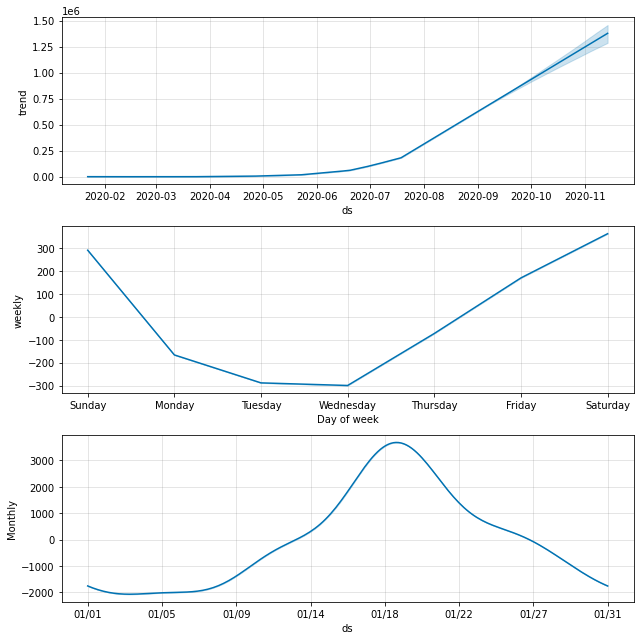

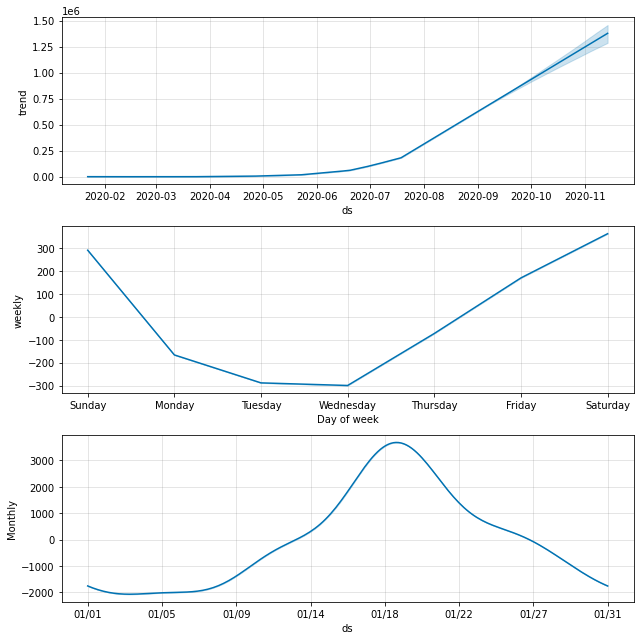

In [ ]:
model_colombia.plot_components(forecast)